## CACTI Radars Analysis: Vertical Profiles:

* Radar data vertical profiles plotting analysis test codes. Focusing on the SAMURAI analysis results.

* Vertical profiles for max. W over specified domain.

**Hungjui Yu 20221004**

In [234]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [235]:
import sys
import multiprocessing as mp

import time
import datetime as dt
from netCDF4 import Dataset # MFDataset
import numpy as np
import xarray as xr
import math

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt
import cartopy.io.shapereader as shpreader
import cartopy.geodesic as cgds
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patheffects as pe
from matplotlib.colors import ( from_levels_and_colors, Normalize )

import metpy.calc as mpcalc
from metpy.interpolate import cross_section

import shapely
from pyproj import Geod


In [236]:
from wrf import ( getvar, interplevel, to_np, get_cartopy, latlon_coords, vertcross
                , cartopy_xlim, cartopy_ylim, interpline, CoordPair, WrfProj
                , xy_to_ll_proj
                )

In [237]:
from pygc import (great_distance, great_circle)

***

## Open data:

### Open SAMURAI data on Maui:

#### Set parameters:

In [238]:
## Path:
# data_path_1 = '/home/hyu/2scratch2/DATA_DOE_CACTI_cases/DATA_Primary_Cases'
data_path_1 = '/home/hyu/2scratch2/DATA_DOE_CACTI_cases/DATA_SAMURAI_tests'

## Date, time:
test_date_time = dt.datetime(2018, 12, 5, 19, 25, 0)

## Test type:
# test_type = 'COW_DOW_1km'
test_type_list = [ 'COW_DOW_1km'
                 , 'COW_DOW_1x1x250m'
                 , 'COW_DOW_1x1x500m'
                 , 'COW_DOW_1km_f21' 
                 ]


#### Read SAMURAI data:

In [239]:
def open_samurai_data(date_time, test_type):

    data_path_2 = '/{}_{}'.format(test_date_time.strftime('%Y%m%d_%H%M'), test_type)

    data_path_full = data_path_1 \
                   + data_path_2 \
                   + '/output/samurai_XYZ_analysis.nc'

    ds_samurai = xr.open_dataset(data_path_full).squeeze()
        
    return ds_samurai


# ds_samurai = open_samurai_data(test_date_time, test_type)


In [240]:
# ds_radar
# ds_radar.WSPD.sel(altitude=5.0).plot()
# ds_samurai.DBZ.sel(altitude=2.0).plot()

### Open radar CFradial data on Maui:

#### Read radar data:

In [241]:
def radar_data_path(date_time, test_type):

    data_path_2 = '/{}_{}'.format(test_date_time.strftime('%Y%m%d_%H%M'), test_type)

    data_path_full = data_path_1 \
                   + data_path_2

    return data_path_full


# cfrad_data_path = radar_data_path(test_date_time, test_type)


***
## Calculations:

### Max. updrafts speed (max. W) vertical profiles:

In [242]:
def vp_max_W_selected(ds_samurai):
    
    ## Max. W all domain:
    da_Wmax = ds_samurai.W.max(dim=['longitude', 'latitude'])

    ## Max. W selected domain:
    da_W_select = ds_samurai.W.sel(longitude=slice(-64.3, -63.6), latitude=slice(-32.2, -31.6))
    da_Wmax_select = da_W_select.max(dim=['longitude', 'latitude'])

    return da_Wmax_select


### Updrafts volume vertical profiles:

In [243]:
def vp_updraft_vol_selected(ds_samurai):

    ## Updrafts threshold:
    updraft_thresh = 5

    ## Updrafts vol. for all domain:
    da_updraft_vol = xr.where( ds_samurai.W>=updraft_thresh, 1, 0 ).sum(dim=['longitude', 'latitude'])
    # da_updraft_vol.plot( y='altitude' )

    ## Updrafts vol. for selected domain:
    da_W_select = ds_samurai.W.sel(longitude=slice(-64.3, -63.6), latitude=slice(-32.2, -31.6))
    da_updraft_vol_select = xr.where( da_W_select>=updraft_thresh, 1, 0 ).sum(dim=['longitude', 'latitude'])

    return da_updraft_vol_select


***
## Creating array:

### Loop thru every test type:

In [244]:
tic = time.time()

for ttypei, ttype in enumerate(test_type_list):
    
    tmp_ds_samurai = open_samurai_data(test_date_time, ttype)
    
    ## Max. updraft speed:
    tmp_da_max_W = vp_max_W_selected(tmp_ds_samurai)
    exec(f'da_max_W_{ttype} = tmp_da_max_W')
    
    ## Updrafts area:
    tmp_da_updraft_area = vp_updraft_vol_selected(tmp_ds_samurai)
    exec(f'da_updraft_area_{ttype} = tmp_da_updraft_area')
    

toc = time.time()
print('Done in {:.4f} seconds'.format(toc-tic))


Done in 4.1960 seconds


***
## Plotting:

### Max. updrafts speed (max. W) vertical profiles:

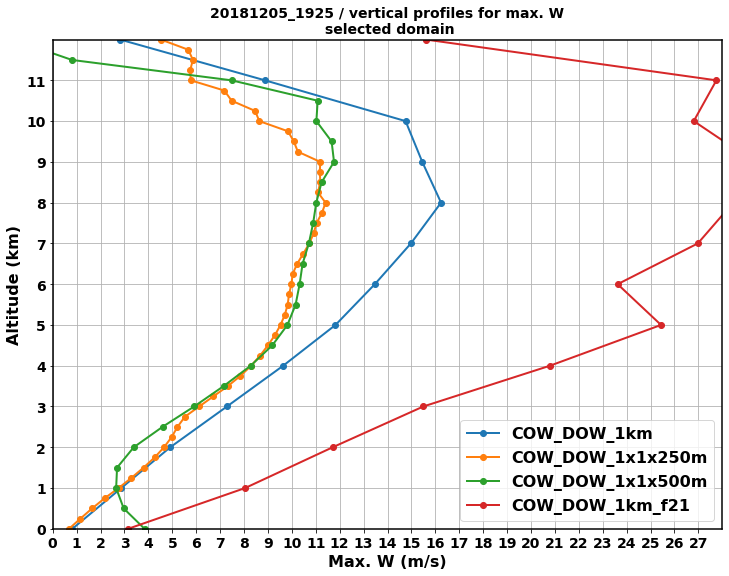

In [233]:
def vert_prof_maxW():
    
    fig, ax1 = plt.subplots(figsize=(12,9))
    
    ## Plot:
    for ttypei, ttype in enumerate(test_type_list):
        tmp_plot_da = eval(f'da_max_W_{ttype}')
        cf1 = tmp_plot_da.plot( y='altitude'
                              , linewidth=2 
                              , marker='o'
                              , label=ttype
                              )
    
    ## Axes:
    for sp in ['top','bottom','left','right']:
        ax1.spines[sp].set_linewidth(1.5)
    ax1.grid()
    ax1.set( xlim=(0, 28), xticks=np.arange(0,28)
           , ylim=(0, 12), yticks=np.arange(0,12)
           )
    ax1.set_xticklabels(ax1.get_xticks(), fontsize=14, fontweight='bold')
    ax1.set_xlabel('Max. W (m/s)', fontsize=16, fontweight='bold')
    ax1.set_yticklabels(ax1.get_yticks(), fontsize=14, fontweight='bold')
    ax1.set_ylabel('Altitude (km)', fontsize=16, fontweight='bold')
    
    ax1.legend( loc='best'
              # , fontsize=16
              , prop={'size': 16, 'weight':'bold'}
              )
    
    ## Title:
    plt.title( test_date_time.strftime('%Y%m%d_%H%M')
             + ' / vertical profiles for max. W'
             + '\n selected domain'
             ,fontsize=14
             ,fontweight='bold'
             # ,loc='left'
             )

    ## Save figure:
    plt.savefig( test_date_time.strftime('%Y%m%d_%H%M')
               + '_VPs_maxW'
               + '.png'
               , bbox_inches='tight'
               , dpi=300
               )
    # plt.close()


vert_prof_maxW()
    

### Updrafts volume (area) vertical profiles:

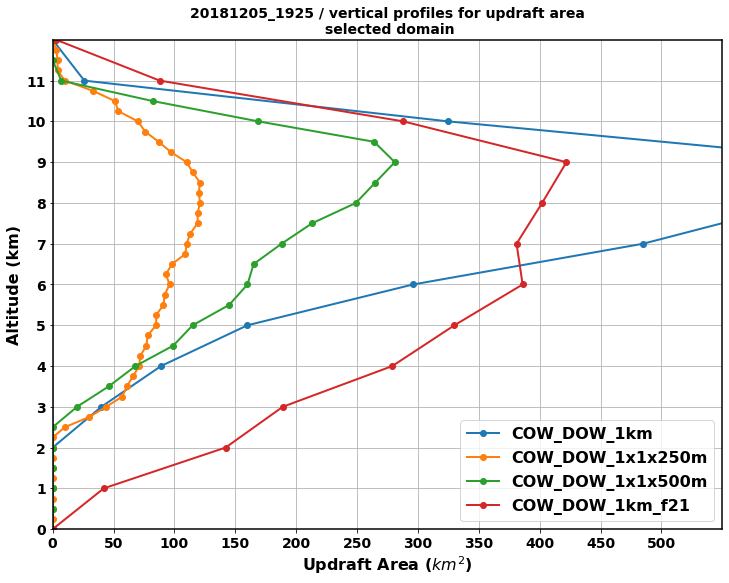

In [248]:
def vert_prof_updraft_vol():
    
    fig, ax1 = plt.subplots(figsize=(12,9))
    
    ## Plot:
    for ttypei, ttype in enumerate(test_type_list):
        tmp_plot_da = eval(f'da_updraft_area_{ttype}')
        cf1 = tmp_plot_da.plot( y='altitude'
                              , linewidth=2 
                              , marker='o'
                              , label=ttype
                              )
    
    ## Axes:
    for sp in ['top','bottom','left','right']:
        ax1.spines[sp].set_linewidth(1.5)
    ax1.grid()
    ax1.set( xlim=(0, 550), xticks=np.arange(0,550,50)
           , ylim=(0, 12), yticks=np.arange(0,12)
           )
    ax1.set_xticklabels(ax1.get_xticks(), fontsize=14, fontweight='bold')
    ax1.set_xlabel('Updraft Area ($km^2$)', fontsize=16, fontweight='bold')
    ax1.set_yticklabels(ax1.get_yticks(), fontsize=14, fontweight='bold')
    ax1.set_ylabel('Altitude (km)', fontsize=16, fontweight='bold')
    
    ax1.legend( loc='best'
              # , fontsize=16
              , prop={'size': 16, 'weight':'bold'}
              )
    
    ## Title:
    plt.title( test_date_time.strftime('%Y%m%d_%H%M')
             + ' / vertical profiles for updraft area'
             + '\n selected domain'
             ,fontsize=14
             ,fontweight='bold'
             # ,loc='left'
             )

    ## Save figure:
    plt.savefig( test_date_time.strftime('%Y%m%d_%H%M')
               + '_VPs_updraft_area'
               + '.png'
               , bbox_inches='tight'
               , dpi=300
               )
    # plt.close()


vert_prof_updraft_vol()
    

***
***
## <font color='dodgerblue'>**Supplement:**</font>

### Set parameters:

#### Radars info:

In [ ]:
## Set site locations lat/lon:
site_locs = { 'CSAPR2': [-64.73, -32.13]
            , 'CHIVO': [-64.17, -31.63]
            , 'RMA1': [-64.191922, -31.441328]
            , 'COW1': [-64.223, -31.986]
            , 'DOW8': [-64.6, -31.8] 
            }

radar_ranges = { 'CSAPR2': 110
               , 'CHIVO': 150
               , 'RMA1': 117
               , 'COW1': 0
               , 'DOW8': 0 
               }

plotting_alt = [1, 2, 3, 5, 10] # km

# print(list(site_locs.keys()))
# for si, sname in enumerate(list(site_locs.keys())):
#     print(sname)

#### Dual-Doppler lobe parameters:

In [ ]:
## Beam-crossing angle:
beam_crossing_angle = 22 #30

## Calculate the dual-Doppler lobes for radar pairs:
# radar_pairs = [ [0, 1], [1, 2], [0, 2] ]
radar_pairs = [ [3, 4] ]

## Colors for radar pairs:
radar_pairs_fcolor = ['blue', 'red', 'green']
radar_pairs_ecolor = ['k', 'darkgrey', 'darkgrey']

### Functions:

#### Great-circle distance:

In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    
    re = 6371.009
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return c * re

# aa = haversine(site_locs['CSAPR2'][1], site_locs['CSAPR2'][0], site_locs['CHIVO'][1], site_locs['CHIVO'][0])
# print(aa)

#### Dual-Doppler lobes:

In [ ]:
def dual_doppler_lobe( radar1_lat, radar1_lon, radar2_lat, radar2_lon, beam_cross_ang ):
    
    ## The centroid (lat/lon) of radars pair:
    cent_lat = (radar1_lat+radar2_lat)/2
    cent_lon = (radar1_lon+radar2_lon)/2
    
    ## The distance between the radars pair:
    dis_dict = great_distance( start_latitude=radar1_lat
                             , start_longitude=radar1_lon
                             , end_latitude=radar2_lat
                             , end_longitude=radar2_lon
                             )
    d2 = dis_dict['distance']/(1e3) #[km]
    # print(d2)
    d2_haver = haversine(radar1_lat, radar1_lon, radar2_lat, radar2_lon)
    # d2 = d2_haver
    
    ## Azimuth between the radars pair:
    az_ang = dis_dict['azimuth']
    # print(az_ang)
    
    ## Dual-Doppler lobe circle radius:
    rr = (d2/2)*(1./np.sin(np.deg2rad(beam_cross_ang)))
    # print(rr)
    
    ## The distance from the centroid of radars pair to the center of the Dual-Doppler lobe circles:
    cc_dis = (d2/2)*(1/np.tan(np.deg2rad(beam_cross_ang)))
    
    ## The 2 centers for the Dual-Doppler lobe circles:
    cent_lobe_dict = great_circle( distance=cc_dis*1e3
                                 , azimuth=[ az_ang+90, az_ang+270 ]
                                 , latitude=cent_lat
                                 , longitude=cent_lon
                                 )
    
    return cent_lobe_dict['latitude'], cent_lobe_dict['longitude'], rr
    
    
# lobe_info = dual_doppler_lobe( site_locs['CSAPR2'][1]
#                              , site_locs['CSAPR2'][0]
#                              , site_locs['CHIVO'][1]
#                              , site_locs['CHIVO'][0]
#                              , 30
#                              )
# lobe_info

#### Creating new map:

In [ ]:
def new_map(fig):
    
#     proj = ccrs.PlateCarree( central_longitude=0.0, globe=None )
    # proj = ccrs.LambertConformal( central_longitude=-64.0, cutoff=-60, globe=None )
    # proj = ccrs.LambertCylindrical( central_longitude=0.0, globe=None )
    # proj = ccrs.Orthographic(-64, -32)
    proj = ccrs.AzimuthalEquidistant(-64, -32)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Add background image:
    # ax.stock_img()
    
    ## Add Stamen terrain:
    stamen_terrain = cimgt.Stamen('terrain')
    ax.add_image(stamen_terrain, 8)
    
    ## Set extent:
    # ax.set_global()
    
    ## S. America:
    # ax.set_extent([-30, -90, 20, -60], crs=ccrs.PlateCarree())
    ## CACTI:
    ax.set_extent([-61.9, -66.1, -30.5, -33.5], crs=ccrs.PlateCarree())
    # ax.set_extent([-62.4, -66.3, -29.6, -33.7], crs=ccrs.PlateCarree())
    # ax.set_extent([-61.4, -67.3, -28.6, -34.7], crs=proj)
    
    ## Add coast lines:
    ax.coastlines()
    # ax.coastlines('10m', 'black', linewidth=1)
    
    ## Grab state shapefile:
#     state_borders = cfeat.NaturalEarthFeature( category='cultural' # 'physical'
#                                              , name='admin_1_states_provinces_lines'
#                                              # , name='geography_regions_elevation_points'
#                                              , scale='110m'
#                                              , facecolor='none'
#                                              , edgecolor='gray'
#                                              # , alpha=0.2
#                                              )
    
    ## Add features:
    # ax.add_feature(cfeat.BORDERS)
    # ax.add_feature(cfeat.LAND)
    # ax.add_feature(cfeat.COASTLINE)
    # ax.add_feature(cfeat.OCEAN, edgecolor=None) #, fc='none')
    # ax.add_feature(cfeat.GSHHSFeature(scale='auto', levels=None))
    # ax.add_feature(state_borders, linewidth=0.8)
        
    ## Add the gridlines:
    latlon_grid_int = 1
    ax_gl = ax.gridlines( crs=ccrs.PlateCarree()
                        , linewidth=0.5
                        , color='#454545' 
                        , alpha=0.9
                        , linestyle='--'
                        , draw_labels=True 
                        , dms=True
                        # , x_inline=False 
                        # , y_inline=False
                        , xlocs=np.arange(-180, 181, latlon_grid_int)
                        , ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 14, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 14, 'weight': 'bold'}
    
    
    return ax

# fig = plt.figure(figsize=(12,12))
# ax1 = new_map(fig)

*** 

### Plot 1: dBZ:

#### Set colormaps:

In [ ]:
## Set NWS reflectivity colorbar:
from metpy.plots import ctables
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', -20, 0.5)

## Set CWB reflectivity colorbar:
clevs = [-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
ccols = ['#ffffff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']
# clevs = [-30,-25,-20,-15,-10,-5,0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,85]
# ccols = ['#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#f0f8ff','#98ffff','#009aff','#1919ff','#19ff19','#19cd19','#19A019','#fefe08','#ffcb00','#ff9c00','#fe0005','#c90200','#9d0000','#9a009d','#cf00d7','#ff00f7','#fdcafe']

#### Plot daigram:

In [ ]:
def run_dbz_map_plot(ds_plot, plotting_alt):
    
    print(str(plotting_alt) + 'km')

    fig = plt.figure(figsize=(12,12))
    ax1 = new_map(fig)

    plotting_var = ds_plot.DBZ.sel(altitude=plotting_alt)
    plotting_lon = ds_plot.longitude
    plotting_lat = ds_plot.latitude


    ## CWB colorbar:
    # cf1 = ax1.contourf( plotting_lon, plotting_lat, plotting_var
    #                   , levels=clevs, colors=ccols
    #                   , alpha=0.8
    #                   )

    ## NWS colorbar:
    cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                        , cmap=ref_cmap, norm=ref_norm
                        , alpha=0.8
                        , shading='auto'
                        , transform=ccrs.PlateCarree() 
                        )

    # cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
    #                     , vmax=70
    #                     , vmin=-5
    #                     , cmap=ctables.registry.get_colortable('NWSReflectivity')
    #                     # , norm=Normalize(-5, 75)
    #                     )

    ## Plot radar ranges:
    # for si, sname in enumerate(list(site_locs.keys())):

    #     ## Use circle-patch:
    # #     ax1.add_patch( plt.Circle( (site_locs[sname][0], site_locs[sname][1])
    # #                              , (radar_ranges[sname]*180)/(6371.009*math.pi)
    # #                              , facecolor='deepskyblue'
    # #                              , edgecolor='k'
    # #                              , alpha=0.2
    # #                              , transform=ccrs.PlateCarree()  
    # #                              )
    # #                  )
    # #     # print((radar_ranges[sname]*180)/(6371.009*math.pi))

    #     ## Use Tissot:
    # #     ax1.tissot( rad_km=radar_ranges[sname]
    # #               , lons=site_locs[sname][0]
    # #               , lats=site_locs[sname][1]
    # #               , n_samples=120
    # #               # , color='skyblue'
    # #               , edgecolor='k'
    # #               , alpha=0.2
    # #               )

    #     ## Use geo:
    #     circle_points = cgds.Geodesic().circle( lon=site_locs[sname][0]
    #                                           , lat=site_locs[sname][1]
    #                                           , radius=radar_ranges[sname]*1e3
    #                                           , n_samples=100
    #                                           , endpoint=False
    #                                           )
    #     geom = shapely.geometry.Polygon(circle_points)
    #     ax1.add_geometries( (geom,)
    #                       , crs=ccrs.PlateCarree()
    #                       # , crs=ccrs.AzimuthalEquidistant(-64, -32)
    #                       , facecolor='none'
    #                       , edgecolor='gray'
    #                       , linewidth=1.5
    #                       , linestyle='--' 
    #                       )

    ## Plot site locations:
    for si, sname in enumerate(list(site_locs.keys())):

        ## Site locations:
        plt.plot( site_locs[sname][0], site_locs[sname][1]
                # , color='k'
                , marker='s'
                , markersize=8
                , mec='k'
                , mew=2.5
                , mfc='w'
                # , markevery=[0,-1]
                # , linewidth=1.0
                # , linestyle='--'
                , transform=ccrs.PlateCarree() 
                )

        ## Site names:
    #     plt.text( site_locs[sname][0], site_locs[sname][1], '  ' + sname + '  '
    #             , fontsize=16
    #             , fontweight='bold'
    #             # , backgroundcolor='w'
    #             , va='top'
    #             , path_effects=[pe.withStroke(linewidth=6, foreground='w')]
    #             , transform=ccrs.PlateCarree() 
    #             )

    ## Cross-sections:
    ## xsec-1:
    # plt.plot( xsec1_LON, xsec1_LAT
    #         , color='k'
    #         , marker='.'
    #         , markersize=14
    #         # , mec='k'
    #         # , mew=1
    #         # , mfc='k'
    #         , markevery=[0,-1]
    #         , linewidth=2.0
    #         , linestyle='--'
    #         )
    # plt.text( xsec1_LON[0], xsec1_LAT[0], ' A '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='top'
    #         )
    # plt.text( xsec1_LON[1], xsec1_LAT[1], ' B '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='bottom'
    #         )
    # ## xsec-2:
    # plt.plot( xsec2_LON, xsec2_LAT
    #         , color='k'
    #         , marker='.'
    #         , markersize=14
    #         # , mec='k'
    #         # , mew=1
    #         # , mfc='k'
    #         , markevery=[0,-1]
    #         , linewidth=2.0
    #         , linestyle='--'
    #         )
    # plt.text( xsec2_LON[0], xsec2_LAT[0], ' C '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='bottom'
    #         )
    # plt.text( xsec2_LON[1], xsec2_LAT[1], ' D '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='top'
    #         )

    cf1_title = plt.title( 'Reflectivity (dBZ) / ' + test_type
                         # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                         + '\n Time: ' + np.datetime_as_string(ds_plot.time.data, unit='s') + 'Z'
                         + ' / Height: ' + str(plotting_alt) + '-km'
                         ,fontsize=16
                         ,fontweight='bold'
                         )

    cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
    cbar = fig.colorbar(cf1, cax=cbar_ax, fraction=0.04)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[dBZ]', fontsize=14, y=-0.1) #fontweight='bold'


    ## Save figure:
    plt.savefig( test_date_time.strftime('%Y%m%d_%H%M')
                 # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
               + '_DBZ_Map'
               + '_' + str(plotting_alt) + 'km'
               + '_' + test_type
               + '.png'
               , bbox_inches='tight'
               , dpi=300
               )
    # plt.close()
    
    
run_dbz_map_plot(ds_samurai, 3)


#### Loop plot (for loop):

In [ ]:
tic = time.time()

for anl_dti, anl_dt in enumerate(anl_date_time_list):

    for ttypei, ttype in enumerate(test_type_list):
        
        print(anl_dt, ttype + '\n')
        
        ds_radar = open_samurai_data(anl_dt, ttype)
        
        test_date_time = anl_dt
        test_type = ttype
        
        for alti, alt in enumerate(plotting_alt):
            run_dbz_map_plot(alt)
        
    
toc = time.time()
print('Done in {:.4f} seconds'.format(toc-tic))


#### Loop plot (multiprocessing):

In [ ]:
tic = time.time()

with mp.Pool(processes=len(plotting_alt)) as pool:
    pool.map(run_dbz_map_plot, plotting_alt)
    pool.close()
    
toc = time.time()
print('Done in {:.4f} seconds'.format(toc-tic))

***

### Map 2: W (and U, V):

#### Set colormaps:

In [ ]:
## W Colormap settings:
w_bounds = np.arange(-16, 17, 2)
w_cmap = cm.get_cmap('RdBu_r', w_bounds.size+1)
w_norm = mpl.colors.BoundaryNorm(w_bounds, w_cmap.N, extend='both')


#### Plot daigram:

In [ ]:
def run_wuv_map_plot(ds_plot, plotting_alt):
    
    print(str(plotting_alt) + 'km')
    
    fig = plt.figure(figsize=(12,12))
    ax1 = new_map(fig)

    ## from SAMURAI:
    plotting_var = ds_plot.W.sel(altitude=plotting_alt)
    plotting_lon = ds_plot.longitude
    plotting_lat = ds_plot.latitude

    ## Plot W:
    cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                        , cmap=w_cmap
                        , norm=w_norm
                        , alpha=0.9
                        , shading='auto'
                        , transform=ccrs.PlateCarree()
                        )

    ## Plot U, V:
    ## from SAMURAI:
    plotting_var_u = ds_plot.U.sel(altitude=plotting_alt).data
    plotting_var_v = ds_plot.V.sel(altitude=plotting_alt).data


    ## from SAMURAI:
    step = 5
    cf_q = ax1.quiver( plotting_lon[::step], plotting_lat[::step]
                     , plotting_var_u[::step, ::step], plotting_var_v[::step, ::step]
                     , scale=800
                     , color='dimgrey'
                     , transform=ccrs.PlateCarree() 
                     )

    cf_qk = ax1.quiverkey( cf_q
                         , 0.95, 0.75
                         , 25
                         , '25m/s'
                         , labelpos='E'
                         , coordinates='figure'
                         , fontproperties={'size': 14, 'weight': 'bold'}
                         )


    ## Plot dual-Doppler lobes:
    for pairi, pair_list in enumerate(radar_pairs):

        ## Get dual-Doppler lobe information:
        lobes = dual_doppler_lobe( site_locs[list(site_locs.keys())[pair_list[0]]][1]
                                 , site_locs[list(site_locs.keys())[pair_list[0]]][0]
                                 , site_locs[list(site_locs.keys())[pair_list[1]]][1]
                                 , site_locs[list(site_locs.keys())[pair_list[1]]][0]
                                 , beam_crossing_angle
                                 )

        ## Plot the 2 lobe circles (use circle-patch):
    #     for ii in [0, 1]:
    #         ax1.add_patch( plt.Circle( (lobes[1][ii], lobes[0][ii])
    #                                  , (lobes[2]*180)/(6371.009*math.pi)
    #                                  , color='k'
    #                                  , linewidth=2.5 
    #                                  , fill=False 
    #                                  , transform=ccrs.PlateCarree()  
    #                                  )
    #                      )

        ## Plot the 2 lobe circles (use Tissot):
        for ii in [0, 1]:
            ax1.tissot( rad_km=lobes[2]
                      , lons=lobes[1][ii]
                      , lats=lobes[0][ii]
                      , n_samples=120
                      , facecolor='none'
                      , edgecolor=radar_pairs_ecolor[pairi]
                      , linestyle='--'
                      , linewidth=1.5
                      # , alpha=0.2
                      )


    ## Plot site locations:
    for si, sname in enumerate(list(site_locs.keys())):

        ## Site locations:
        plt.plot( site_locs[sname][0], site_locs[sname][1]
                # , color='k'
                , marker='s'
                , markersize=8
                , mec='k'
                , mew=2.5
                , mfc='w'
                # , markevery=[0,-1]
                # , linewidth=1.0
                # , linestyle='--'
                , transform=ccrs.PlateCarree() 
                )

    ## Cross-sections:
    ## xsec-1:
    # plt.plot( xsec1_LON, xsec1_LAT
    #         , color='k'
    #         , marker='.'
    #         , markersize=14
    #         # , mec='k'
    #         # , mew=1
    #         # , mfc='k'
    #         , markevery=[0,-1]
    #         , linewidth=2.0
    #         , linestyle='--'
    #         )
    # plt.text( xsec1_LON[0], xsec1_LAT[0], ' A '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='top'
    #         )
    # plt.text( xsec1_LON[1], xsec1_LAT[1], ' B '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='bottom'
    #         )
    # ## xsec-2:
    # plt.plot( xsec2_LON, xsec2_LAT
    #         , color='k'
    #         , marker='.'
    #         , markersize=14
    #         # , mec='k'
    #         # , mew=1
    #         # , mfc='k'
    #         , markevery=[0,-1]
    #         , linewidth=2.0
    #         , linestyle='--'
    #         )
    # plt.text( xsec2_LON[0], xsec2_LAT[0], ' C '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='bottom'
    #         )
    # plt.text( xsec2_LON[1], xsec2_LAT[1], ' D '
    #         , fontsize=18
    #         , fontweight='bold'
    #         , va='top'
    #         )

    cf1_title = plt.title( 'W and U, V (m/s) / ' + test_type
                         + ' / Beam-crossing angle: ' + str(beam_crossing_angle) + '\N{DEGREE SIGN}'
                         # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                         + '\n Time: ' + np.datetime_as_string(ds_plot.time.data, unit='s') + 'Z'
                         + ' / Height: ' + str(plotting_alt) + '-km'
                         ,fontsize=16
                         ,fontweight='bold'
                         )

    cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
    cbar = fig.colorbar(cf1, fraction=0.04, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m/s]', fontsize=14, y=-0.2) #fontweight='bold'


    ## Save figure:
    plt.savefig( test_date_time.strftime('%Y%m%d_%H%M')
                 # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
               + '_W_Map'
               + '_' + str(plotting_alt) + 'km'
               + '_' + test_type
               + '.png'
               , bbox_inches='tight'
               , dpi=300
               )
    # plt.close()


run_wuv_map_plot(ds_samurai, 3)



#### Loop plot (for loop):

In [ ]:
tic = time.time()

for anl_dti, anl_dt in enumerate(anl_date_time_list):

    for ttypei, ttype in enumerate(test_type_list):
        
        print(anl_dt, ttype + '\n')
        
        ds_radar = open_samurai_data(anl_dt, ttype)
        
        test_date_time = anl_dt
        test_type = ttype

        for alti, alt in enumerate(plotting_alt):
            run_wuv_map_plot(alt)
            
    
toc = time.time()
print('Done in {:.4f} seconds'.format(toc-tic))


### Open radar data from local:

In [ ]:
# test_method = 'SAMURAI'
# test_time = dt.datetime(2019, 1, 25, 22, 0, 0)

# # ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis_m.nc')
# ds_radar = xr.open_dataset('/Users/yuhungjui/Downloads/samurai_XYZ_analysis.nc')

### Parameters: Primary events:

In [ ]:
anl_date_time_list = [ dt.datetime(2018, 12, 5, 19, 30, 0)
                     , dt.datetime(2018, 12, 14, 2, 0, 0)
                     , dt.datetime(2018, 12, 14, 2, 30, 0)
                     , dt.datetime(2018, 12, 14, 3, 0, 0)
                     , dt.datetime(2018, 12, 14, 3, 30, 0)
                     , dt.datetime(2018, 12, 14, 4, 0, 0)
                     , dt.datetime(2019, 1, 25, 20, 0, 0)
                     , dt.datetime(2019, 1, 25, 20, 30, 0)
                     , dt.datetime(2019, 1, 25, 21, 0, 0) 
                     ]

test_type_list = [ 'SAMURAI_QC', 'SAMURAI_QC_reg5' ]

#### Plot horizontal wind speed:

In [ ]:
## Wind Speed Colormap settings:
ws_bounds = np.arange(0, 51, 5)
ws_cmap = cm.get_cmap('Oranges', ws_bounds.size+1)
ws_norm = mpl.colors.BoundaryNorm(ws_bounds, ws_cmap.N, extend='max')


In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

plotting_var = np.sqrt( ds_radar.U.sel(altitude=plot_alt).data[0]**2
                      + ds_radar.V.sel(altitude=plot_alt).data[0]**2 
                      )
plotting_lon = ds_radar.longitude
plotting_lat = ds_radar.latitude

## Plot W:
cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=ws_cmap
                    , norm=ws_norm
                    , alpha=0.9
                    , shading='auto')

## Plot U, V:
plotting_var_u = ds_radar.U.sel(altitude=plot_alt).data[0]
plotting_var_v = ds_radar.V.sel(altitude=plot_alt).data[0]
step = 8
cf_q = ax1.quiver( plotting_lon[::step], plotting_lat[::step]
                 , plotting_var_u[::step, ::step], plotting_var_v[::step, ::step]
                 , scale=800
                 , color='dimgrey'
                 )
cf_qk = ax1.quiverkey( cf_q
                     , 0.95, 0.75
                     , 25
                     , '25m/s'
                     , labelpos='E'
                     , coordinates='figure'
                     , fontproperties={'size': 14, 'weight': 'bold'}
                     )


## Loc. CSAPR2:
plt.plot( -64.73, -32.13
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Loc. CHIVO:
plt.plot( -64.17, -31.63
        # , color='k'
        , marker='x'
        , markersize=14
        , mec='k'
        , mew=3
        , mfc='none'
        # , markevery=[0,-1]
        # , linewidth=1.0
        # , linestyle='--'
        )

## Cross-sections:
## xsec-1:
plt.plot( xsec1_LON, xsec1_LAT
        , color='k'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )
plt.text( xsec1_LON[0], xsec1_LAT[0], ' A '
        , fontsize=18
        , fontweight='bold'
        , va='top'
        )
plt.text( xsec1_LON[1], xsec1_LAT[1], ' B '
        , fontsize=18
        , fontweight='bold'
        , va='bottom'
        )
## xsec-2:
plt.plot( xsec2_LON, xsec2_LAT
        , color='k'
        , marker='.'
        , markersize=14
        # , mec='k'
        # , mew=1
        # , mfc='k'
        , markevery=[0,-1]
        , linewidth=2.0
        , linestyle='--'
        )
plt.text( xsec2_LON[0], xsec2_LAT[0], ' C '
        , fontsize=18
        , fontweight='bold'
        , va='bottom'
        )
plt.text( xsec2_LON[1], xsec2_LAT[1], ' D '
        , fontsize=18
        , fontweight='bold'
        , va='top'
        )

cf1_title = plt.title( 'Retrieved Hor. Wind Speed'
                     # + test_time.strftime('%Y-%m-%d T%H:%M:%SZ') 
                     + '\n Time: ' + np.datetime_as_string(ds_radar.time.data[0], unit='s') + 'Z'
                     + ' / Height: ' + str(plot_alt) + '-km'
                     + ' \n Method: ' + test_method
                     ,fontsize=16
                     ,fontweight='bold'
                     )

cbar_ax = fig.add_axes([0.95, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cf1, fraction=0.04, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_title('[m/s]', fontsize=14, y=-0.2) #fontweight='bold'


## Save figure:
plt.savefig( test_time.strftime('%Y%m%d_%H%M%S')
             # './' + ds_radar.time.data[0].astype('datetime64[s]').item().strftime('%Y%m%d_%H%M%S')
           + '_map_WS_xline.png'
           , bbox_inches='tight'
           , dpi=300
           )
